# Import Model

In [1]:
from python_scripts.pretrain_model import PretrainedEncoderRegressor
import torch.nn as nn

name = 'AE_Center_noaug'

checkpoint_path = f"AE_model/128/{name}/best.pt"

# 1) 实例化（会自动加载并冻结 encoder）
model = PretrainedEncoderRegressor(
    ae_checkpoint=checkpoint_path,
    ae_type="center",
    tile_dim=128,
    center_dim=128,
    neighbor_dim=128,
    output_dim=35
)

# 2) monkey‐patch 一个新的 head
model.decoder  = nn.Sequential(
    nn.Linear(128+128+128, 256),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),
    nn.Linear(64, 35)
    
)

# 3) 再次检查只训练 head
# for name, p in model.named_parameters():
#     print(name, p.requires_grad)



# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 141,987 / 6,679,843


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/pretrain_model.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(ae_checkpoint, map_

## Load Model

# Import training data

## Same in multiple .pt

In [134]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/only_realign_S1_S2/Macenko_masked/filtered/train_data"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(fpath, map_location='cpu')


Loaded keys: dict_keys(['subtiles', 'slide_idx', 'tile', 'source_idx', 'position', 'label'])
Samples: 8349


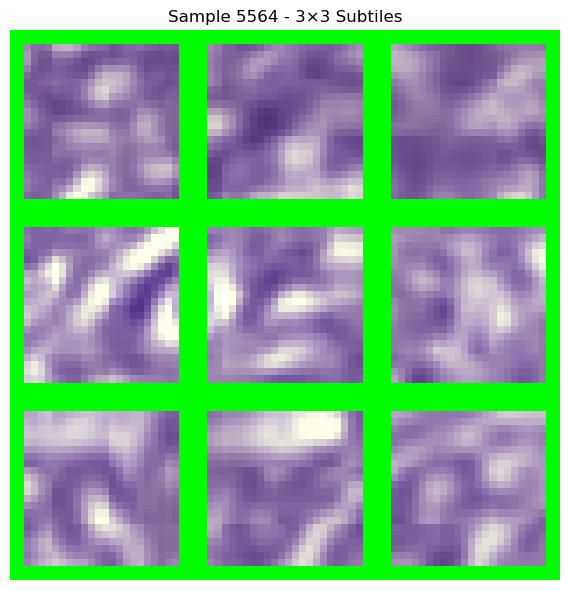

In [130]:
from python_scripts.validate_input import visualize_random_from_grouped_data

visualize_random_from_grouped_data(grouped_data, subtile_grid_size=3)

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import convert_item
# assume convert_item and get_model_inputs are already defined
# assume convert_item and get_model_inputs are already defined

import torch
import numpy as np
from torch.utils.data import Dataset

# assume convert_item and get_model_inputs are already defined

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        # Check consistent lengths
        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"Field '{key}' length {len(value)} != expected {expected_length}")

        # Ensure forward keys and label exist
        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"Missing required field '{key}' for model forward")
        if 'label' not in self.data:
            raise ValueError("Missing 'label' field in data_dict")

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        # model inputs
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            if key in self.image_keys:
                tensor = convert_item(value, is_image=True)
            else:
                tensor = convert_item(value, is_image=False)
            sample[key] = tensor.float()

        # label
        label = self.transform(self.data['label'][idx])
        sample['label'] = convert_item(label, is_image=False).float()

                # slide_idx
                # slide_idx as raw
        if 'slide_idx' in self.data:
            sid = self.data['slide_idx'][idx]
            sample['slide_idx'] = sid

        return sample

    def check_item(self, idx=0, num_lines=5):
        # unchanged
        pass



def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
        # 5) 补 slide_idx，全都标为 "S_7"
    out["slide_idx"] = ["S_7"] * dataset_size
    return out


In [135]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs



image_keys = [ 'tile', 'subtiles']


# 用法示例
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko_only_use_S1_S2/test_dataset.pt", model)


# 把 test_data_dict 里所有 ndarray / tensor 都转成 list
for key, val in test_dataset.items():
    print(key, type(val))
    # 如果是 torch.Tensor
    if isinstance(val, torch.Tensor):
        test_dataset[key] = val.cpu().tolist()
    # 如果是 numpy.ndarray
    elif isinstance(val, np.ndarray):
        test_dataset[key] = val.tolist()
    # 否则留着（比如 slide_idx 本身就是 list）

# 然后统一用 list + list
combined = {}
for key, train_vals in test_dataset.items():
    if key in test_dataset:
        combined[key] = train_vals + grouped_data[key]
    else:
        combined[key] = train_vals


# 最后构造 Dataset
image_keys = ['tile','subtiles']
full_dataset = importDataset(
    data_dict   = combined,
    model       = model,
    image_keys  = image_keys,
    transform   = lambda x: x,
    print_sig   = True
)

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_59038/1794571483.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu"

⚠️ 从 'tile' 推断样本数量: 2088
tile <class 'list'>
subtiles <class 'list'>
label <class 'torch.Tensor'>
slide_idx <class 'list'>
Model forward signature: (tile, subtiles)


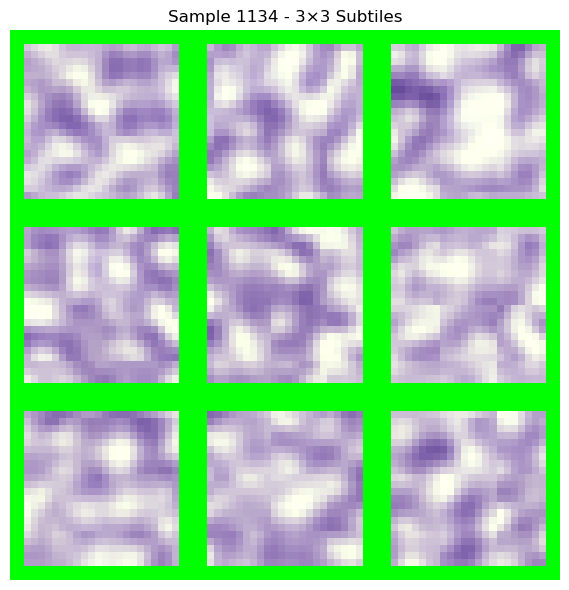

In [136]:
from python_scripts.validate_input import visualize_random_from_grouped_data

visualize_random_from_grouped_data(test_dataset, subtile_grid_size=3)

In [148]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity



class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]

        return self.fc(torch.cat([g, m], dim=1))


class SubtileEncoder(nn.Module):
    """多尺度 Subtile 分支：局部信息 + 两层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        l = self.large_pool(x).contiguous().reshape(B, N, -1)

        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m, l], dim=2).mean(dim=1).contiguous()  # [B, total_dim]
        return self.fc(feat)
class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3, negative_slope= 0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)
        l = self.large_pool(x).contiguous().reshape(x.size(0), -1)

        return self.fc(torch.cat([g, m, l], dim=1)).contiguous()



class VisionMLP_MultiTask(nn.Module):
    """整體多任務模型：融合 tile + subtile + center，使用動態權重融合"""
    def __init__(self, tile_dim=128, subtile_dim=64, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.encoder_center  = CenterSubtileEncoder(subtile_dim)

        # 融合層：輸入三個分支的 concat，輸出三個 gate
        self.gate_fc = nn.Sequential(
            nn.Linear(tile_dim + subtile_dim + subtile_dim, 64),
            nn.LeakyReLU(negative_slope),
            nn.Linear(64, 3),  # 對 tile, subtile, center 分支輸出 gate
            nn.Softmax(dim=1)  # 轉成權重
        )

        # 輸出 decoder：輸入為 tile_dim (因為融合後只剩一個 vector)
        self.decoder = nn.Sequential(
            nn.Linear(tile_dim + subtile_dim + subtile_dim, 256),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim),
        )

    def forward(self, tile, subtiles):
        tile = tile.contiguous()
        subtiles = subtiles.contiguous()
        center = subtiles[:, 4]

        f_tile = self.encoder_tile(tile)         # [B, tile_dim]
        f_sub  = self.encoder_subtile(subtiles)  # [B, subtile_dim]
        f_center = self.encoder_center(center)   # [B, subtile_dim]

        # 拼接三個分支做 gating
        features_cat = torch.cat([f_tile, f_sub, f_center], dim=1)  # [B, tile+sub+center]
        gates = self.gate_fc(features_cat)  # [B, 3]

        # 對三個分支做 weighted sum
        f_fused = (
            gates[:, 0:1] * f_tile + 
            gates[:, 1:2] * f_sub + 
            gates[:, 2:3] * f_center
        )  # [B, tile_dim]（注意：需保證 f_tile == f_sub == f_center 的維度）

        return self.decoder(f_fused)
    
class VisionMLP_MultiTask(nn.Module):
    """整體多任務模型：融合 tile + subtile + center + position 特徵"""
    def __init__(self, tile_dim=128, subtile_dim=128, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.encoder_center  = CenterSubtileEncoder(subtile_dim)

        self.feature_dim = tile_dim + subtile_dim + subtile_dim # +2 for position(x,y)

        self.decoder = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim),
        )

    def forward(self, tile, subtiles):
        tile = tile.contiguous()
        subtiles = subtiles.contiguous()
        center = subtiles[:, 4]

        f_tile = self.encoder_tile(tile)         # [B, tile_dim]
        f_sub  = self.encoder_subtile(subtiles)  # [B, subtile_dim]
        f_center = self.encoder_center(center)   # [B, subtile_dim]

        # 拼接特徵向量與座標
        features_cat = torch.cat([f_tile, f_sub, f_center], dim=1)  # [B, tile+sub+center+2]

        return self.decoder(features_cat)


# 用法示例
model = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)


# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = model.to(device)
model.load_state_dict(torch.load("output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/only_S1_S2/stain_nor_with_S1_S2/Macenko_masked/fold1/best_model.pt", map_location="cpu"))
model.to(device).eval()

Trainable / total params = 6,679,843 / 6,679,843


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_59038/1442184137.py:287: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("output_fo

VisionMLP_MultiTask(
  (encoder_tile): DeepTileEncoder(
    (layer0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


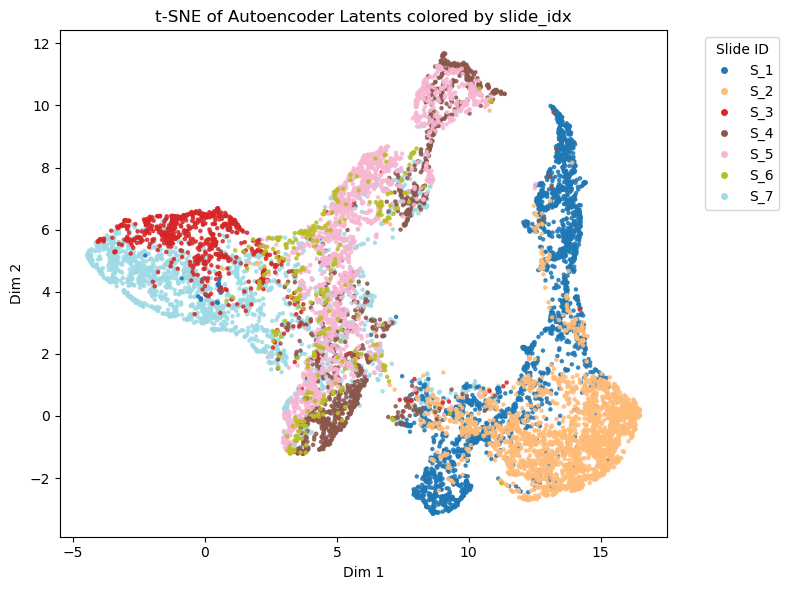

In [149]:
from torch.utils.data import Subset, DataLoader

# 2) 提取潜在向量 & 对应的 slide_idx
#model.eval()
latents = []
slide_ids = []

with torch.no_grad():
    for batch in DataLoader(full_dataset, batch_size=64, shuffle=False):
        # 特征部分不变
        tiles    = batch['tile'].to(device)
        subtiles = batch['subtiles'].to(device)
        subtiles = subtiles.contiguous()
        tiles     = tiles.contiguous()
        f_c = model.encoder_center(subtiles[:, 4])         # (B, center_dim)
        f_n = model.encoder_subtile(subtiles)                # (B, neighbor_dim)
        f_t = model.encoder_tile(tiles)                     # (B, tile_dim)

        features_cat = torch.cat([f_c, f_n, f_t], dim=1)        # (B, fusion_dim)
        h        = features_cat

        latents.append(h.cpu())

        # # 拼接三個特徵計算 gate
        # gates = model.gate_fc(features_cat)        # (B, 3), softmax over features

        # # 動態融合 latent 向量
        # f_fused = (
        #     gates[:, 0:1] * f_t +
        #     gates[:, 1:2] * f_n +
        #     gates[:, 2:3] * f_c
        # )  # (B, tile_dim) — 注意各 encoder 輸出維度要一致

        # latents.append(f_fused.cpu())

        # 这里不要 .numpy()，直接 extend 列表
        sids = batch['slide_idx']   # 这是一个 list
        slide_ids.extend(sids)
        

# 最后转成 numpy array
latents   = torch.cat(latents, dim=0).numpy()
slide_ids = np.array(slide_ids)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# latents, slide_ids 已经准备好
unique_slides, slide_codes = np.unique(slide_ids, return_inverse=True)

# tsne = TSNE(n_components=2, random_state=42)
# proj = tsne.fit_transform(latents)
import umap

proj = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42) \
               .fit_transform(latents) 
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    proj[:,0], proj[:,1],
    c=slide_codes,
    cmap='tab20',
    s=5, alpha=0.8
)

# 自定义图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter.cmap(scatter.norm(code)),
           markersize=6,
           label=slide_name)
    for code, slide_name in enumerate(unique_slides)
]

plt.legend(
    handles=legend_elements,
    title="Slide ID",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Autoencoder Latents colored by slide_idx")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()



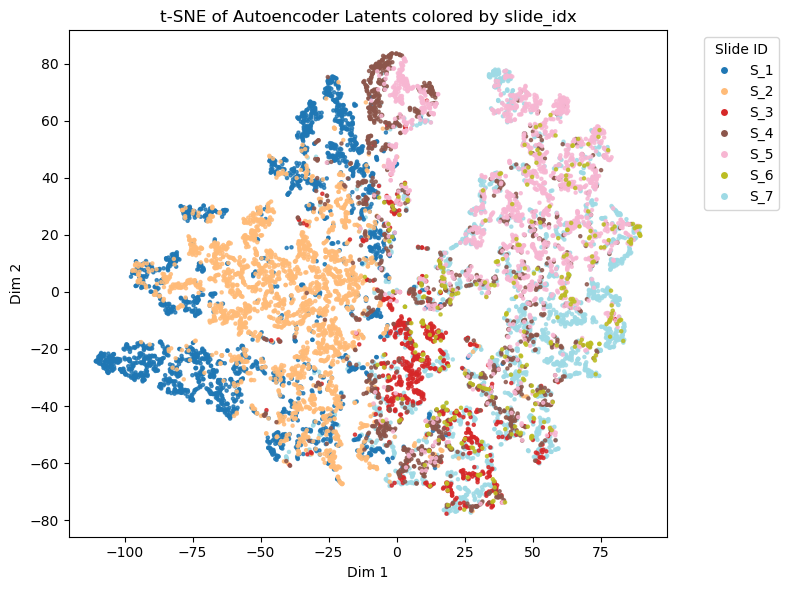

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# latents, slide_ids 已经准备好
unique_slides, slide_codes = np.unique(slide_ids, return_inverse=True)

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    proj[:,0], proj[:,1],
    c=slide_codes,
    cmap='tab20',
    s=5, alpha=0.8
)

# 自定义图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter.cmap(scatter.norm(code)),
           markersize=6,
           label=slide_name)
    for code, slide_name in enumerate(unique_slides)
]

plt.legend(
    handles=legend_elements,
    title="Slide ID",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Autoencoder Latents colored by slide_idx")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()


# Spot 降維

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1) 定义一个简单的 Tabular Autoencoder
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim=35, latent_dim=8):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# 2) 封装 Dataset
class SpotDataset(Dataset):
    def __init__(self, matrix: np.ndarray):
        """
        matrix: shape (N_spots, 35)，预处理后的特征矩阵
        """
        self.data = torch.from_numpy(matrix).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 3) 训练函数
def train_autoencoder(
    data_matrix: np.ndarray,
    latent_dim: int = 8,
    batch_size: int = 64,
    lr: float = 1e-3,
    n_epochs: int = 50,
    device: str = "cpu"
):
    ds = SpotDataset(data_matrix)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = TabularAutoencoder(input_dim=data_matrix.shape[1], latent_dim=latent_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(1, n_epochs+1):
        model.train()
        tot_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_loss += loss.item() * batch.size(0)
        tot_loss /= len(ds)
        if epoch % 10 == 0 or epoch==1:
            print(f"Epoch {epoch}/{n_epochs}  Recon MSE: {tot_loss:.4f}")
    return model


# Data

In [82]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
#with h5py.File("dataset/filtered&masked_dataset.h5", "r") as f:

with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: 對每一個 spot 的 cell abundances 進行排名
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

# 建立一個新的 DataFrame 儲存排名資訊
ranked_df = all_train_spots_df.copy()

# 對每一行做排名（axis=1）
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)
# 原始 abundance | 排名 (ordinal)
# 最大值 | 最大 rank（數字 最大）
# 最小值 | 1

# 用 "rank_" + 原本欄位名稱
ranked_values.columns = [f"rank_{col}" for col in cell_type_cols]

# 再和原資料合併
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)

✅ 已讀取 slide: S_1
✅ 已讀取 slide: S_2
✅ 已讀取 slide: S_3
✅ 已讀取 slide: S_4
✅ 已讀取 slide: S_5
✅ 已讀取 slide: S_6


## original_log2_z_score_rank

In [83]:

# suppose `ranked_df` has columns rank_C1…rank_C35 plus slide_name
cell_cols = [f"C{i}" for i in range(1,36)]
original_log2_z_score = all_train_spots_df.copy()

# per‐slide zscore
# 之后再做 scaled、log2_coeff、wranks 就和之前一样
original_log2_z_score[cell_cols] = np.log2(original_log2_z_score[cell_cols])
                  
# 1) 计算每个 slide 的全局 mean & std
slide_stats = (
    original_log2_z_score
    .groupby("slide_name")[cell_cols]
    .apply(lambda sub: pd.Series({
        "slide_mean": sub.values.flatten().mean(),
        "slide_std":  sub.values.flatten().std()
    }))
    .reset_index()
)

# 2) 把这两个字段 merge 回原 df
original_log2_z_score = original_log2_z_score.merge(slide_stats, on="slide_name", how="left")

# 3) 用同一组 slide_mean/slide_std 做归一化
original_log2_z_score[cell_cols] = (original_log2_z_score[cell_cols] - original_log2_z_score["slide_mean"].values[:, None]) \
                / original_log2_z_score["slide_std"].values[:, None]

# （可选）删掉临时列
original_log2_z_score.drop(columns=["slide_mean","slide_std"], inplace=True)

original_log2_z_score[cell_cols] = original_log2_z_score[cell_cols] - original_log2_z_score[cell_cols].min().min() +1

# suppose `ranked_df` has columns rank_C1…rank_C35 plus slide_name
cell_cols = [f"C{i}" for i in range(1,36)]
original_log2_z_score_rank = original_log2_z_score.copy()
rank_cols = [f"rank_C{i}" for i in range(1,36)]
# per‐slide zscore
# 之后再做 scaled、log2_coeff、wranks 就和之前一样
# 假设 original_log2_z_score_rank 和 ranked_df 在行顺序上是对应的
orig_vals = original_log2_z_score_rank[cell_cols].to_numpy()   # shape (N,35)
rank_vals = ranked_df      [rank_cols].to_numpy()              # shape (N,35)

# 逐元素相乘
new_vals = orig_vals * rank_vals

# 赋回 DataFrame
original_log2_z_score_rank[cell_cols] = new_vals



## df_log2_ranks

In [84]:
##df_log2_ranks


cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]

# 1) 计算每个 slide 的最小表达（跨所有 spots、所有 cell types）
slide_min = (
    all_train_spots_df
    .groupby('slide_name')[cell_cols]    # cell_cols = ['C1','C2',…,'C35']
    .min()                               # 得到 DataFrame: index=slide_name, columns=cell_cols
    .min(axis=1)                         # 再对 cell_cols axis=1 取最小 -> Series, index=slide_name
)

# 2) 把这个 slide 最小值映射回每一行
min_expr = (
    all_train_spots_df['slide_name']
    .map(slide_min)                      # Series 长度 N
    .values
    .reshape(-1, 1)                      # 变成 (N,1)
)



expr  = all_train_spots_df[cell_cols].values    # (N,35)
ranks = ranked_df[rank_cols].values             # (N,35)
df_log2_ranks = ranked_df.copy()

# 之后再做 scaled、log2_coeff、wranks 就和之前一样
scaled     = expr / min_expr * 2
log2_coeff = np.log2(scaled)
wranks     = log2_coeff * ranks
# 直接替换 ranked_df 中的 rank 列
for i, col in enumerate(rank_cols):
    df_log2_ranks[col] = wranks[:, i]



## Train 

In [ ]:
# 4) 准备不同预处理的数据
#    假设 all_spots: 原始表达矩阵 shape (N,35)

cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]
data_A = original_log2_z_score_rank[cell_cols].values  # raw counts or log2 etc.
data_B = df_log2_ranks[rank_cols].values  # raw counts or log2 etc.


# 5) 分别训练
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training Autoencoder on raw log2 …")
ae_A = train_autoencoder(data_A, latent_dim=8, n_epochs=50, device=device)
print("Training Autoencoder on per-slide min-max …")
ae_B = train_autoencoder(data_B, latent_dim=8, n_epochs=50, device=device)
print("Training Autoencoder on quantile uniform …")

# 6) 提取所有 latent 向量，做 UMAP 可视化
import umap
def get_latents(ae, data):
    with torch.no_grad():
        z = ae.encoder(torch.from_numpy(data).float().to(device))
        return z.cpu().numpy()

latents_A = get_latents(ae_A, data_A)
latents_B = get_latents(ae_B, data_B)

reducer = umap.UMAP(random_state=42)
emb_A = reducer.fit_transform(latents_A)
emb_B = reducer.fit_transform(latents_B)

# 绘图对比
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3,figsize=(12,4))
for emb, title, ax in zip([emb_A,emb_B],
                          ["raw log2","per-slide min-max","quantile"],
                          axs):
    ax.scatter(emb[:,0], emb[:,1], s=5, alpha=0.8)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()


Training Autoencoder on raw log2 …
Epoch 1/50  Recon MSE: 7522.9334
Epoch 10/50  Recon MSE: 1137.7520
Epoch 20/50  Recon MSE: 938.9856
Epoch 30/50  Recon MSE: 874.9552
Epoch 40/50  Recon MSE: 846.5324
Epoch 50/50  Recon MSE: 799.9916
Training Autoencoder on per-slide min-max …
Epoch 1/50  Recon MSE: 116698.3086
Epoch 10/50  Recon MSE: 16707.7757
Epoch 20/50  Recon MSE: 14942.4109
Epoch 30/50  Recon MSE: 13293.7931
Epoch 40/50  Recon MSE: 13040.7249
Epoch 50/50  Recon MSE: 12106.8598
Training Autoencoder on quantile uniform …


NameError: name 'ae_C' is not defined

In [88]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_umap_features(
    *,
    df: pd.DataFrame = None,
    latents: np.ndarray = None,
    feature_cols: list = None,
    latent_idxs: list = None,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    random_state: int = 42,
    cmap: str = "viridis",
    point_size: int = 5,
    alpha: float = 0.8,
    ncols: int = 7,
    uniform_cmap: bool = True
):
    """
    通用 UMAP 可视化：支持 DataFrame+feature_cols 或 Latent matrix+latent_idxs。

    参数:
      df           : 如果你要可视化 DataFrame 中的列，传入 df 和 feature_cols；
      latents      : 如果你直接用 latent 向量，可传 latents（N×D）和 latent_idxs（要上色的维度列表）；
      feature_cols : DataFrame 中要可视化的列名列表；
      latent_idxs  : latent 数组中要可视化的维度索引列表；
      其余参数同 plot_all_rank_umaps。
    """
    # 准备要可视化的矩阵 X 和 label arrays
    if df is not None and feature_cols is not None:
        X_in = df[feature_cols].values.astype(float)
        labels = {col: df[col].values for col in feature_cols}
        keys = feature_cols
    elif latents is not None and latent_idxs is not None:
        X_in = latents[:, latent_idxs].astype(float)
        labels = {f"latent_{i}": latents[:, i] for i in latent_idxs}
        keys = [f"latent_{i}" for i in latent_idxs]
    else:
        raise ValueError("必须传入 (df + feature_cols) 或 (latents + latent_idxs)。")

    # 1) UMAP 降维
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    emb = reducer.fit_transform(X_in)
    umap1, umap2 = emb[:,0], emb[:,1]

    # 2) 计算 Spearman ρ（UMAP1 vs 每个 feature/latent）
    rhos = []
    for k in keys:
        rho, _ = spearmanr(umap1, labels[k])
        rhos.append(abs(rho))
    avg_rho = float(np.mean(rhos))
    print(f"Average abs(Spearman rho): {avg_rho:.3f}")

    # 3) 准备色标范围
    if uniform_cmap:
        all_vals = np.vstack([labels[k] for k in keys])
        vmin, vmax = all_vals.min(), all_vals.max()
    else:
        vmin = vmax = None

    # 4) 绘制网格图
    n_plots = len(keys)
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*3, nrows*2.5),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (k, rho) in zip(axes, zip(keys, rhos)):
        sc = ax.scatter(umap1, umap2,
                        c=labels[k],
                        cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        s=point_size, alpha=alpha)
        ax.set_title(f"{k} (ρ={rho:.2f})", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

    # 删除多余子图
    for ax in axes[n_plots:]:
        ax.remove()
    plt.tight_layout()
    plt.show()

    # 5) 条形图：所有 rho 值
    rho_df = pd.DataFrame({
        "feature": keys,
        "rho": rhos
    }).set_index("feature")
    plt.figure(figsize=(ncols*0.8, nrows*0.6))
    rho_df["rho"].plot(kind="bar")
    plt.ylabel("abs(Spearman ρ)")
    plt.axhline(0, color="k", linewidth=0.5)
    plt.title("Continuity along UMAP1")
    plt.tight_layout()
    plt.show()


In [94]:
list(range(latents_A[0]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [91]:
plot_umap_features(
    latents=latents_A,      # shape (N, latent_dim)
    latent_idxs=list(range(latents_A[0])),  # 比如 [0,1,2,3,…]
    ncols=4,                # 按你的 latent_dim 调整网格
    uniform_cmap=False
)

TypeError: only integer scalar arrays can be converted to a scalar index